In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import rdFMCS
import pandas as pd
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from IPython.display import display, Image
from IPython.core.display import HTML
from pathlib import Path

<IPython.core.display.Javascript object>

In [3]:
DATADIR = Path(_dh[0]).parent / "data"

<IPython.core.display.Javascript object>

### Choose screening deck

,Name,Smiles,Mol
0,Saquinavir,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C@H]([C@H](CC3=CC=CC=C3)NC(=O)[C@H](CC(=O)N)NC(=O)C4=NC5=CC=CC=C5C=C4)O,
1,Lopinavir,CC1=C(C(=CC=C1)C)OCC(=O)N[C@@H](CC2=CC=CC=C2)[C@H](C[C@H](CC3=CC=CC=C3)NC(=O)[C@H](C(C)C)N4CCCNC4=O)O,
2,Tipranavir,CCC[C@]1(CC(=C(C(=O)O1)[C@H](CC)C2=CC(=CC=C2)NS(=O)(=O)C3=NC=C(C=C3)C(F)(F)F)O)CCC4=CC=CC=C4,
3,Darunavir,CC(C)CN(C[C@H]([C@H](CC1=CC=CC=C1)NC(=O)O[C@H]2CO[C@@H]3[C@H]2CCO3)O)S(=O)(=O)C4=CC=C(C=C4)N,
4,Amprenavir,CC(C)CN(C[C@H]([C@H](CC1=CC=CC=C1)NC(=O)O[C@H]2CCOC2)O)S(=O)(=O)C3=CC=C(C=C3)N,
5,Atazanavir,CC(C)(C)[C@@H](C(=O)N[C@@H](CC1=CC=CC=C1)[C@H](CN(CC2=CC=C(C=C2)C3=CC=CC=N3)NC(=O)[C@H](C(C)(C)C)NC(=O)OC)O)NC(=O)OC,
6,Ritonavir,CC(C)C1=NC(=CS1)CN(C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CC2=CC=CC=C2)C[C@@H]([C@H](CC3=CC=CC=C3)NC(=O)OCC4=CN=CS4)O,

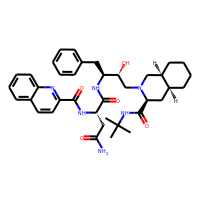
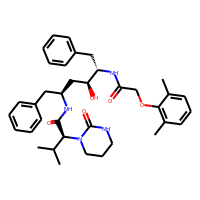
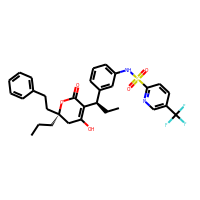
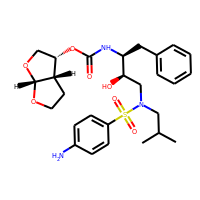
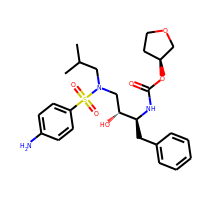
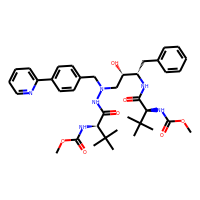
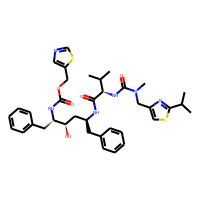

<IPython.core.display.Javascript object>

In [4]:
fname = "proteaseFDAdrugs"
df_screen = pd.read_csv(DATADIR / f"{fname}.csv", sep=";")
# add molecule column
PandasTools.AddMoleculeColumnToFrame(df_screen, "Smiles", "Mol")
display(HTML(df_screen.to_html()))

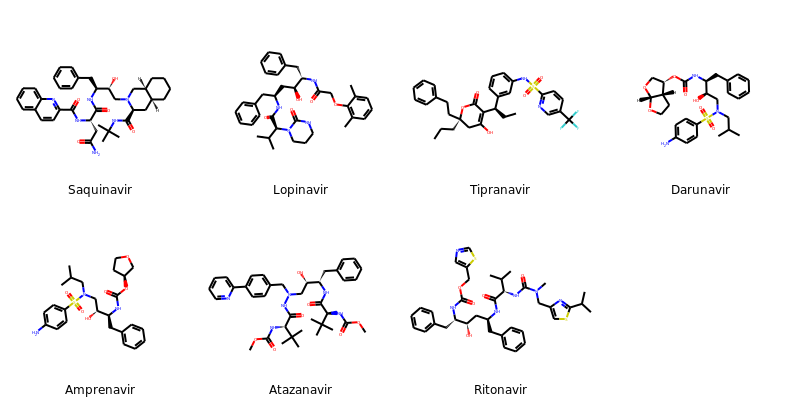

<IPython.core.display.Javascript object>

In [5]:
Draw.MolsToGridImage(df_screen.Mol, legends=df_screen.Name.to_list(), molsPerRow=4)

### Choose fragment set

,ID,Smiles,Mol,NumHeavyAtoms
0,Mpro-x0072,CS(=O)(=O)NCCc1ccccc1,,13
1,Mpro-x0104,CC(=O)NCCc1c[nH]c2ccc(F)cc12,,16
2,Mpro-x0107,CC(=O)Nc1cnccc1C,,11
3,Mpro-x0161,COC(=O)c1ccc(S(N)(=O)=O)cc1,,14
4,Mpro-x0195,CN1CCCc2ccc(S(N)(=O)=O)cc21,,15
5,Mpro-x0305,CCNc1ccc(C#N)cn1,,11
6,Mpro-x0354,Cc1ccc(OCC(=O)N2CCN(C)CC2)cc1,,18
7,Mpro-x0387,OC1CCN(Cc2ccsc2)CC1,,13
8,Mpro-x0395,Cc1nnc(CN2CCC=C(F)C2)s1,,14
9,Mpro-x0397,Cc1cc(CN(C)C(=O)NC2CC2)no1,,15

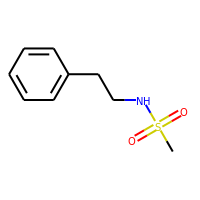
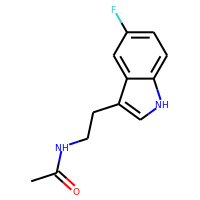
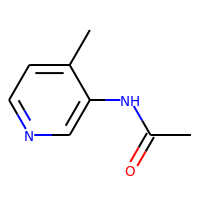
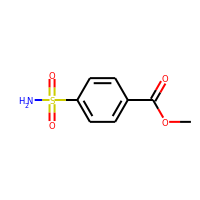
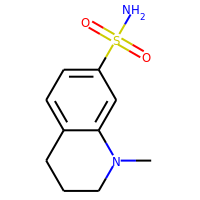
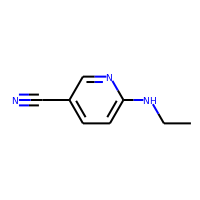
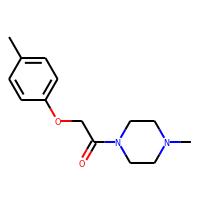
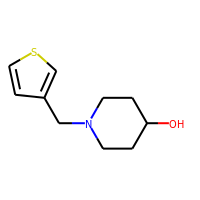
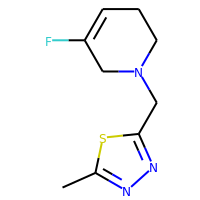
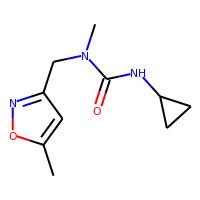
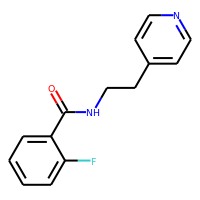
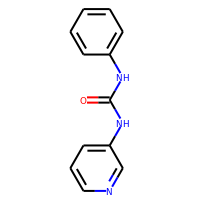
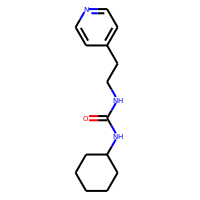
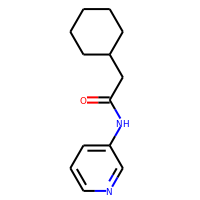
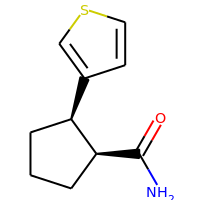
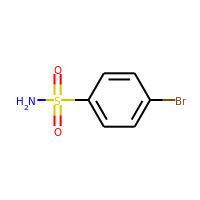
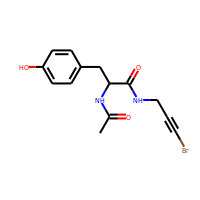
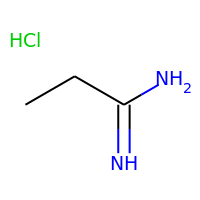
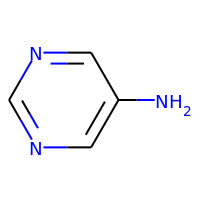
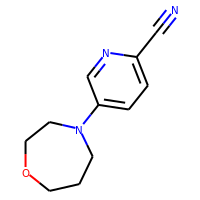
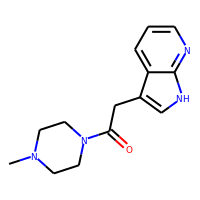
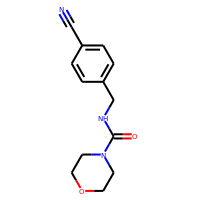

<IPython.core.display.Javascript object>

In [6]:
sdf_file = DATADIR / "fragments" / "non_covalent_fragments2D.sdf"
df_frag = PandasTools.LoadSDF(str(sdf_file), smilesName="Smiles", molColName="Mol")
df_frag["NumHeavyAtoms"] = df_frag.apply(lambda x: x["Mol"].GetNumHeavyAtoms(), axis=1)
display(HTML(df_frag.to_html()))

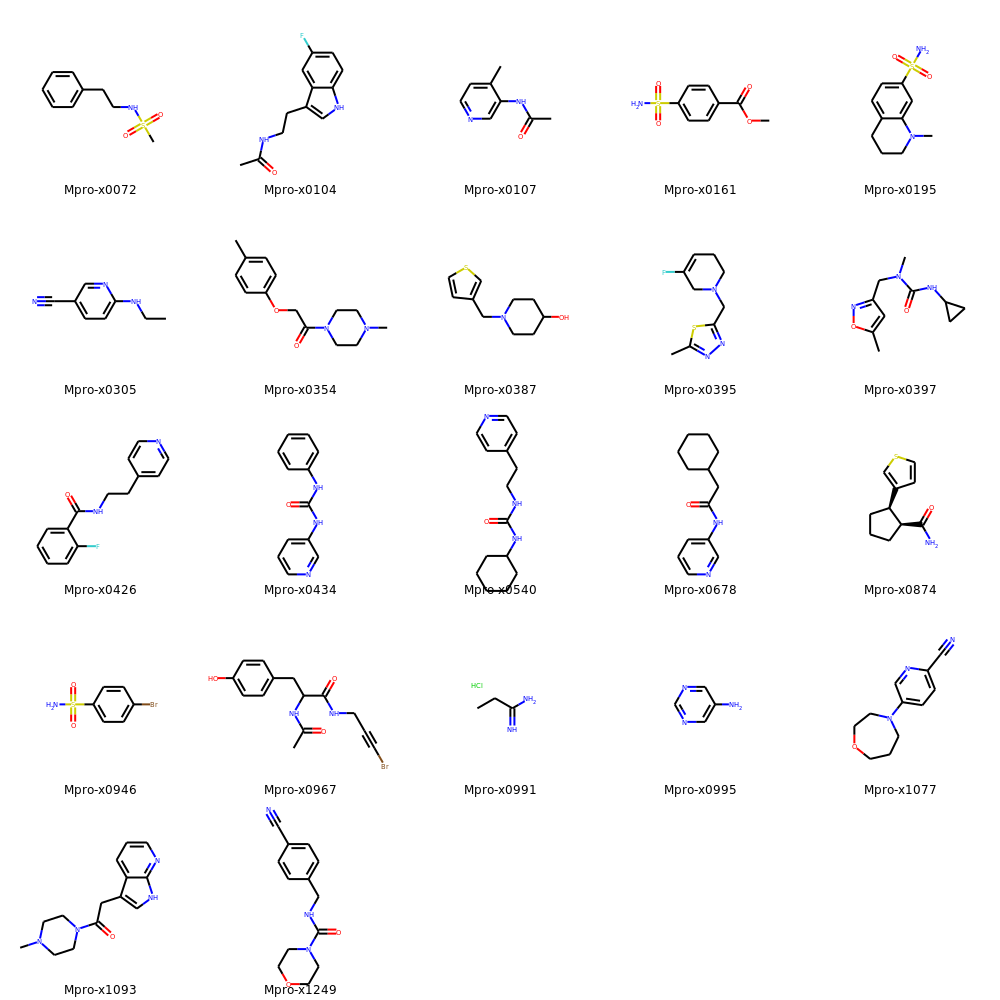

<IPython.core.display.Javascript object>

In [7]:
Draw.MolsToGridImage(df_frag.Mol, legends=df_frag.ID.to_list(), molsPerRow=5)

## Add most similar fragment and similarity value to screening deck

In [8]:
most_sim_frag_name = []
most_sim_frag_smiles = []
most_sim_frag_score = []

# loop over screening library
for screen_idx, screen_row in df_screen.iterrows():
    screen_fp = AllChem.GetMorganFingerprint(screen_row.Mol, 2)
    sim = 0.0
    frag = "non"
    smi = "non"
    # loop over fragments to find most similar one
    for frag_idx, frag_row in df_frag.iterrows():
        frag_fp = AllChem.GetMorganFingerprint(frag_row.Mol, 2)
        tmp_sim = DataStructs.DiceSimilarity(screen_fp, frag_fp)
        if tmp_sim > sim:
            sim = tmp_sim
            frag = frag_row.ID
            smi = frag_row.Smiles
    # store data of most similar fragment
    most_sim_frag_name.append(frag)
    most_sim_frag_score.append(sim)
    most_sim_frag_smiles.append(smi)
df_screen["simFragName"] = most_sim_frag_name
df_screen["simFragSmiles"] = most_sim_frag_smiles
df_screen["simFragScore"] = most_sim_frag_score
df_screen.sort_values(["simFragScore"], ascending=False).head()

,Name,Smiles,Mol,simFragName,simFragSmiles,simFragScore
4,Amprenavir,CC(C)CN(C[C@H]([C@H](CC1=CC=CC=C1)NC(=O)O[C@H]...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",Mpro-x0072,CS(=O)(=O)NCCc1ccccc1,0.388060
2,Tipranavir,CCC[C@]1(CC(=C(C(=O)O1)[C@H](CC)C2=CC(=CC=C2)N...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",Mpro-x0072,CS(=O)(=O)NCCc1ccccc1,0.366013
3,Darunavir,CC(C)CN(C[C@H]([C@H](CC1=CC=CC=C1)NC(=O)O[C@H]...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",Mpro-x0072,CS(=O)(=O)NCCc1ccccc1,0.363636
6,Ritonavir,CC(C)C1=NC(=CS1)CN(C)C(=O)N[C@@H](C(C)C)C(=O)N...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",Mpro-x0434,O=C(Nc1ccccc1)Nc1cccnc1,0.308511
5,Atazanavir,CC(C)(C)[C@@H](C(=O)N[C@@H](CC1=CC=CC=C1)[C@H]...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",Mpro-x0967,CC(=O)NC(Cc1ccc(O)cc1)C(=O)NCC#CBr,0.307692


<IPython.core.display.Javascript object>

## Get maximum common substructure (MCS) between compounds and fragments

In [9]:
# Highlight the fragment MCS in the query molecules
def highlight_fragments(cur_mols, frag):
    matching = []
    cur_mols.append(frag)
    for mol in cur_mols:
        cur_mcs = rdFMCS.FindMCS(
            [mol, frag], ringMatchesRingOnly=True, completeRingsOnly=True
        )
        pattern = Chem.MolFromSmarts(cur_mcs.smartsString)
        matching.append(mol.GetSubstructMatch(pattern))
    return Draw.MolsToGridImage(
        cur_mols, molsPerRow=5, highlightAtomLists=matching, subImgSize=(300, 250)
    )

<IPython.core.display.Javascript object>

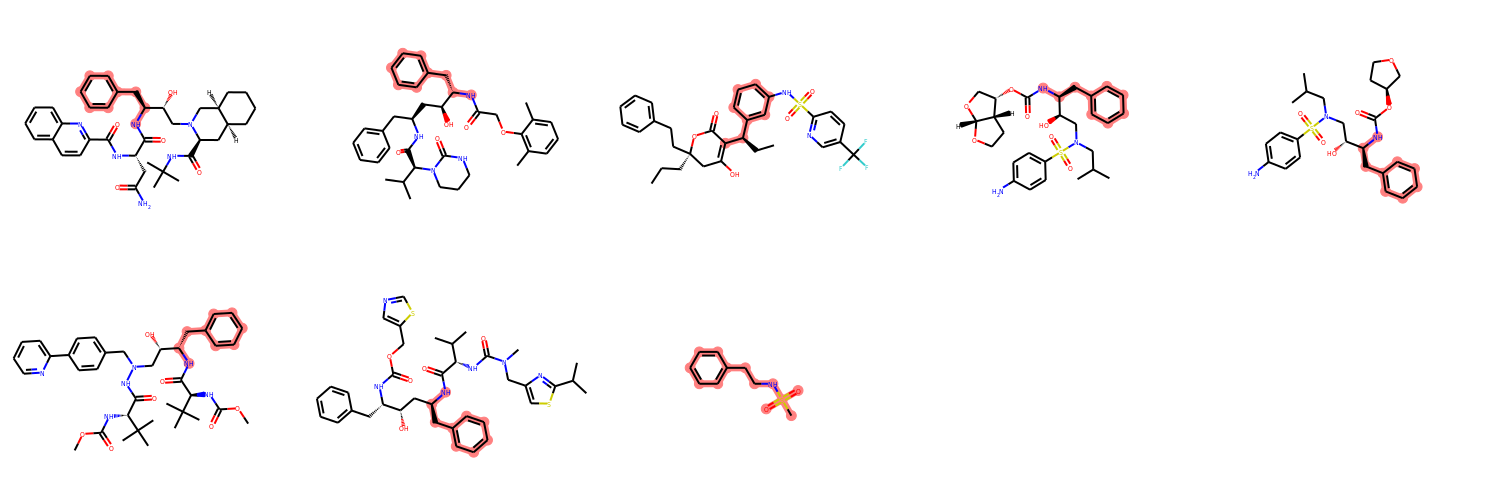

<IPython.core.display.Javascript object>

In [10]:
highlight_fragments(list(df_screen.Mol.values), df_frag.Mol.iloc[0])

### Store fragment with 'best' match per compound

In [11]:
from rdkit.Chem import rdFMCS

mcs_frag_name = []
mcs_frag_smiles = []
mcs_frag_ratio = []

# loop over screening library
for screen_idx, screen_row in df_screen.iterrows():
    mol = screen_row.Mol
    ratio = 0
    frag_id = "non"
    frag_smiles = "non"
    # loop over fragments to find mcs
    for frag_idx, frag_row in df_frag.iterrows():
        frag = frag_row.Mol
        # get molecule fragment mcs smarts string
        match = rdFMCS.FindMCS(
            [mol, frag], ringMatchesRingOnly=True, completeRingsOnly=True
        ).smartsString
        mcs_mol = Chem.MolFromSmarts(match)
        # get ratio of fragment that was matched (by heavy atom count)
        tmp_ratio = mcs_mol.GetNumAtoms() / float(frag.GetNumAtoms())
        if tmp_ratio > ratio:
            ratio = tmp_ratio
            frag_id = frag_row.ID
            frag_smiles = frag_row.Smiles
    mcs_frag_name.append(frag_id)
    mcs_frag_smiles.append(frag_smiles)
    mcs_frag_ratio.append(ratio)

df_screen["mcsFragName"] = mcs_frag_name
df_screen["mcsFragSmiles"] = mcs_frag_smiles
df_screen["mcsFragRatio"] = mcs_frag_ratio
df_screen.sort_values(["mcsFragRatio"], ascending=False).head()
df_screen.head(10)

,Name,Smiles,Mol,simFragName,simFragSmiles,simFragScore,mcsFragName,mcsFragSmiles,mcsFragRatio
0,Saquinavir,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",Mpro-x0967,CC(=O)NC(Cc1ccc(O)cc1)C(=O)NCC#CBr,0.300518,Mpro-x0195,CN1CCCc2ccc(S(N)(=O)=O)cc21,0.733333
1,Lopinavir,CC1=C(C(=CC=C1)C)OCC(=O)N[C@@H](CC2=CC=CC=C2)[...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",Mpro-x0967,CC(=O)NC(Cc1ccc(O)cc1)C(=O)NCC#CBr,0.302703,Mpro-x0995,Nc1cncnc1,0.857143
2,Tipranavir,CCC[C@]1(CC(=C(C(=O)O1)[C@H](CC)C2=CC(=CC=C2)N...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",Mpro-x0072,CS(=O)(=O)NCCc1ccccc1,0.366013,Mpro-x0305,CCNc1ccc(C#N)cn1,0.636364
3,Darunavir,CC(C)CN(C[C@H]([C@H](CC1=CC=CC=C1)NC(=O)O[C@H]...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",Mpro-x0072,CS(=O)(=O)NCCc1ccccc1,0.363636,Mpro-x0946,NS(=O)(=O)c1ccc(Br)cc1,0.909091
4,Amprenavir,CC(C)CN(C[C@H]([C@H](CC1=CC=CC=C1)NC(=O)O[C@H]...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",Mpro-x0072,CS(=O)(=O)NCCc1ccccc1,0.388060,Mpro-x0946,NS(=O)(=O)c1ccc(Br)cc1,0.909091
5,Atazanavir,CC(C)(C)[C@@H](C(=O)N[C@@H](CC1=CC=CC=C1)[C@H]...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",Mpro-x0967,CC(=O)NC(Cc1ccc(O)cc1)C(=O)NCC#CBr,0.307692,Mpro-x0072,CS(=O)(=O)NCCc1ccccc1,0.692308
6,Ritonavir,CC(C)C1=NC(=CS1)CN(C)C(=O)N[C@@H](C(C)C)C(=O)N...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",Mpro-x0434,O=C(Nc1ccccc1)Nc1cccnc1,0.308511,Mpro-x0072,CS(=O)(=O)NCCc1ccccc1,0.692308


<IPython.core.display.Javascript object>

In [12]:
# Highlight the fragment MCS in the query molecules
def highlight_best_fragments(cur_mols, frag_smiles, labels):
    matching = []
    for i in range(0, len(cur_mols)):
        mol = cur_mols[i]
        frag = Chem.MolFromSmiles(frag_smiles[i])
        cur_mcs = rdFMCS.FindMCS(
            [mol, frag], ringMatchesRingOnly=True, completeRingsOnly=True
        )
        pattern = Chem.MolFromSmarts(cur_mcs.smartsString)
        matching.append(mol.GetSubstructMatch(pattern))
    return Draw.MolsToGridImage(
        cur_mols,
        molsPerRow=5,
        highlightAtomLists=matching,
        legends=list(labels),
        subImgSize=(300, 250),
    )

<IPython.core.display.Javascript object>

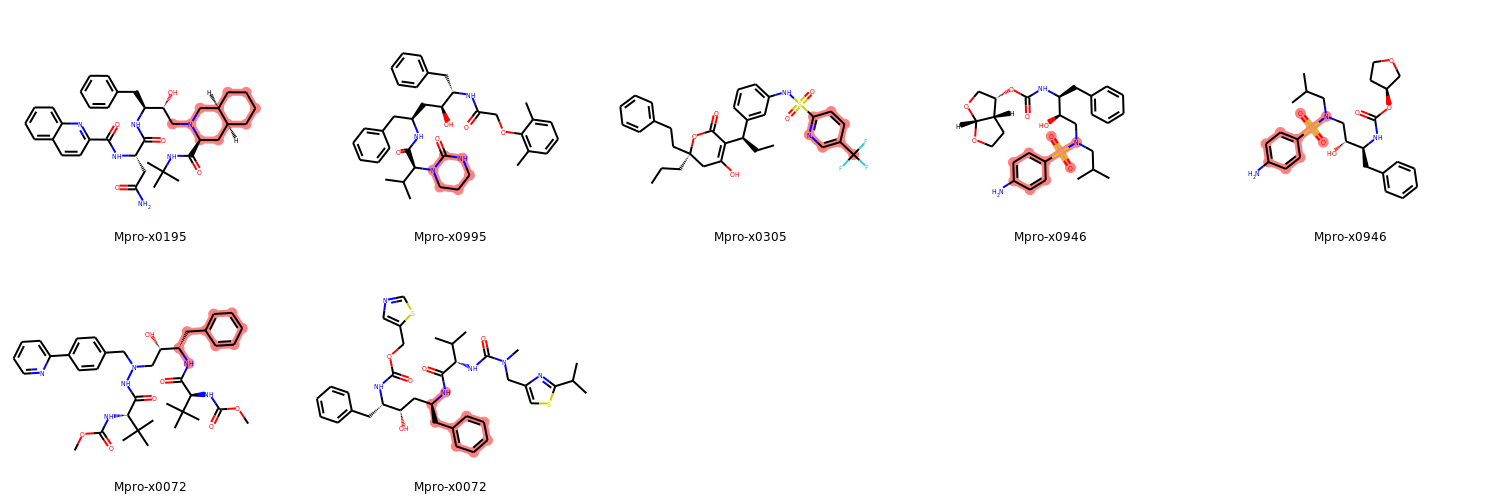

<IPython.core.display.Javascript object>

In [13]:
highlight_best_fragments(
    df_screen.Mol.values, df_screen.mcsFragSmiles.values, df_screen.mcsFragName.values
)

['Mpro-x0195', 'Mpro-x0995', 'Mpro-x0305', 'Mpro-x0946', 'Mpro-x0946', 'Mpro-x0072', 'Mpro-x0072']


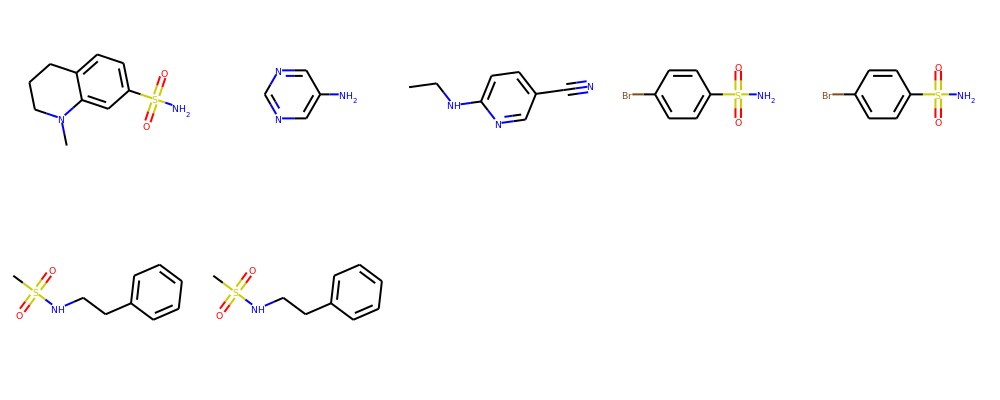

<IPython.core.display.Javascript object>

In [14]:
mols = [Chem.MolFromSmiles(x) for x in df_screen.mcsFragSmiles]
names = [x for x in df_screen.mcsFragName]
print(names)
Draw.MolsToGridImage(mols, molsPerRow=5)

## store dataset filtered by similarity to fragment or MCS with fragment

In [16]:
filter_crit = "mcs075"
value = 0.75
df_filter = df_screen[df_screen.mcsFragRatio > value]
print(df_screen.shape, df_filter.shape)
df_filter.drop(["Mol"], axis=1).to_csv(DATADIR / f"{fname}_{filter_crit}.csv")

(7, 9) (3, 9)


<IPython.core.display.Javascript object>